# 5 Unsupervised Clustering - Investigating San Francisco Housing Prices Through Police Incident Reports and 311 Cases<a id='Unsupervised_Clustering'></a>

## 1 Contents<a id='1_Contents'></a>
* [Unsupervised Clustering - Investigating San Francisco Housing Prices Through Police Incident Reports and 311 Cases](#Unsupervised_Clustering)
  * [1 Contents](#1_Contents)
  * [2 Introduction](#2_Introduction)
  * [3 Imports](#3_Imports)
  * [4 Load The Data](#4_Load_The_Data)
  * [5 Prepare data](#5_Prepare_data)
  * [6 K-Means Clustering](#6_K-Means_Clustering)
    * [6.1 Function for evaluating models](#6.1_Function_for_evaluating_models)
    * [6.2 Choosing K](#6.2_Choosing_K)
      * [6.2.1 The Elbow Method](#6.2.1_The_Elbow_Method)
      * [6.2.2 The Silhouette Method](#6.2.2_The_Silhouette_Method)
      * [6.2.3 Evaluation](#6.2.3_Evaluation)
    * [6.3 Applying PCA](#6.3_Applying_PCA)
      * [6.3.1 The Elbow Method](#6.3.1_The_Elbow_Method)
      * [6.3.2 Evaluation](#6.3.2_Evaluation)
    * [6.4 In-depth look at model results](#6.4_In-depth_look_at_model_results)    
  * [7 Other Models](#7_Other_Models)
    * [7.1 Affinity Propagation](#7.1_Affinity_Propagation)
    * [7.2 Agglomerative Clustering](#7.2_Agglomerative_Clustering)
  * [8 Cluster Analysis](#8_Cluster_Analysis)


## 2 Introduction<a id='2_Introduction'></a>

In this notebook, we will use an unsupervised learning approach to view the San Francisco police incident reports and 311 cases. __We want to create clusters of our data points and then compare them to the Neighborhood labels.__

We will use the file `Post_EDA_SF_Combined_SFPD_311_Housing.csv` that was created in our previous Jupyter Notebook, `2-Exploratory_Data_Analysis.ipynb`. This file contains all SF police incident reports, 311 cases, and housing sales data aggregated by month and by neighborhood, from January 2018 up to and including September 2020, wherein each row is an observation with a distinct pairing on month-year and each column represents a possible feature to be used in modelling.

## 3 Imports<a id='3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 4 Load The Data<a id='4_Load_The_Data'></a>

In [2]:
df = pd.read_csv('../data/Post_EDA_SF_Combined_SFPD_311_Housing.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 82 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Year Month                                    1188 non-null   int64  
 1   Neighborhood                                  1188 non-null   object 
 2   Arson                                         1188 non-null   int64  
 3   Assault                                       1188 non-null   int64  
 4   Burglary                                      1188 non-null   int64  
 5   Case Closure                                  1188 non-null   int64  
 6   Civil Sidewalks                               1188 non-null   int64  
 7   Courtesy Report                               1188 non-null   int64  
 8   Disorderly Conduct                            1188 non-null   int64  
 9   Drug Offense                                  1188 non-null   i

## 5 Prepare data<a id='5_Prepare_data'></a>

In order to prepare the data for our `KMeans` clustering model, we must:

  1. Filter out the columns 'Year Month', 'Neighborhood', and 'Median Sale Price'. We are specifically looking at clustering based on only police incident and 311 case data.
  2. Scale the data. In our previous `4-Modeling.ipynb` notebook, we determined that `MinMaxScaler` provided our best results.

In [4]:
removed_col_list = ['Year Month', 'Neighborhood','Median Sale Price']
removed_col_values = df[removed_col_list]
x_cols = df.drop(columns=removed_col_list)
x_cols.shape

(1188, 79)

In [5]:
scaler = MinMaxScaler()
scaler.fit(x_cols)
x_cols_scaled = scaler.transform(x_cols)

In [6]:
# Review the scaled after-effects on X_train
pd.set_option('display.max_rows', None)
display(pd.DataFrame(x_cols_scaled).describe().T)
pd.reset_option('display.max_rows')

,count,mean,std,min,25%,50%,75%,max
0,1188.0,0.081650,0.144019,0.0,0.000000,0.000000,0.100000,1.0
1,1188.0,0.138029,0.194046,0.0,0.036232,0.065217,0.123188,1.0
2,1188.0,0.152563,0.146907,0.0,0.056604,0.103774,0.188679,1.0
3,1188.0,0.051217,0.100107,0.0,0.000000,0.000000,0.076923,1.0
4,1188.0,0.009937,0.054949,0.0,0.000000,0.000000,0.000000,1.0
5,1188.0,0.051300,0.107181,0.0,0.000000,0.000000,0.055556,1.0
6,1188.0,0.133017,0.163743,0.0,0.023810,0.071429,0.142857,1.0
7,1188.0,0.036038,0.109681,0.0,0.000000,0.004444,0.017778,1.0
8,1188.0,0.020370,0.086625,0.0,0.000000,0.000000,0.000000,1.0
9,1188.0,0.057344,0.128734,0.0,0.000000,0.000000,0.125000,1.0


## 6 K-Means Clustering<a id='6_K-Means_Clustering'></a>

Let's look at using K-Means Clustering.

### 6.1 Function for evaluating models<a id='6.1_Function_for_evaluating_models'></a>

We will define a function to compute and store model results for evaluation. This method is specifically for K-Means, and the differentiator will be the `n_clusters` for each model.

In [7]:
# takes in as arguments: 
# k_clusters : number of clusters in model
# df_complete_results : dataframe in which to store computed results
# cluster_labels : the predicted cluster labels from the model
def kmeans_evaluate_models(k_clusters, df_complete_results, cluster_labels):
    kmm_ct = pd.crosstab(removed_col_values['Neighborhood'], cluster_labels)
    kmm_results = pd.DataFrame( kmm_ct.max(axis=1) ).rename(columns={0:"correct"})
    kmm_results['accuracy'] = kmm_results.correct * 100 // 33
    kmm_results['n_incorrect_clusters'] = kmm_ct.astype(bool).sum(axis=1) - 1
    kmm_results['k_clusters'] = k_clusters
    # add to final results table
    df_complete_results = df_complete_results.append( pd.melt(kmm_results.drop(columns=["correct"])).assign(k_clusters=k_clusters) )
    # must return or the dataframe won't actually change
    return(df_complete_results)

### 6.2 Choosing K<a id='6.2_Choosing_K'></a>

We need to choose K. Let's look at how many neighborhoods we have, as that is the max number of clusters we should see.

In [8]:
len(removed_col_values['Neighborhood'].unique())

36

#### 6.2.1 The Elbow Method<a id='6.2.1_The_Elbow_Method'></a>

We will first use the elbow method.

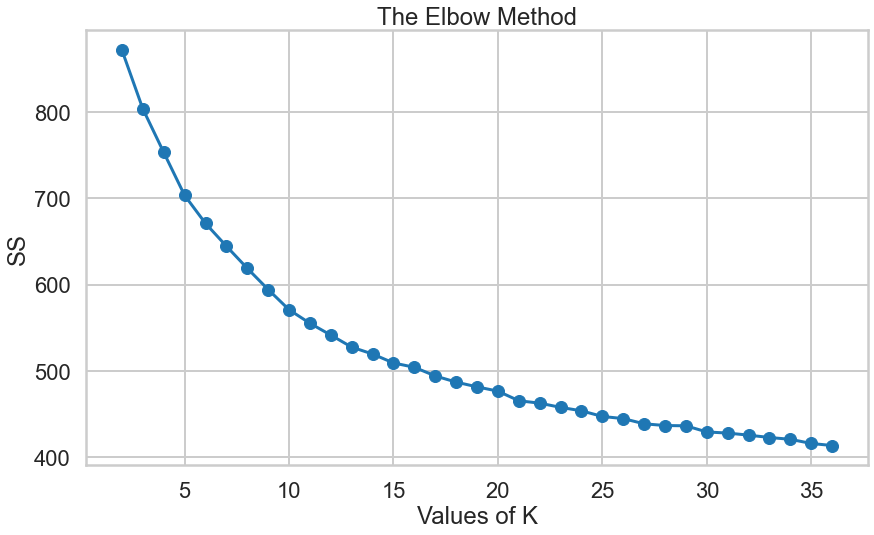

In [9]:
# plotting Elbow method
inertias = list()
K = range(2,37)

for k in K:
    kmeansModel = KMeans(n_clusters=k, random_state=42)
    kmeansModel.fit(x_cols_scaled)
    inertias.append(kmeansModel.inertia_) 

plt.figure(figsize=(14,8))
plt.plot(K, inertias, marker='o') 
plt.xlabel('Values of K') 
plt.ylabel('SS') 
plt.title('The Elbow Method') 
plt.show() 

There doesn't appear to be a distinct elbow here, let's look at the silhouette method.

#### 6.2.2 The Silhouette Method<a id='6.2.2_The_Silhouette_Method'></a>

We will use the silhouette score.

For k = 2 The average silhouette_score is : 0.5891643388325427
For k = 3 The average silhouette_score is : 0.5456170138884002
For k = 4 The average silhouette_score is : 0.15616670432618873
For k = 5 The average silhouette_score is : 0.16148031134935278
For k = 6 The average silhouette_score is : 0.17061113901678523
For k = 7 The average silhouette_score is : 0.1755082910763002
For k = 8 The average silhouette_score is : 0.173668000158623
For k = 9 The average silhouette_score is : 0.1599431613452731
For k = 10 The average silhouette_score is : 0.08078484007281578


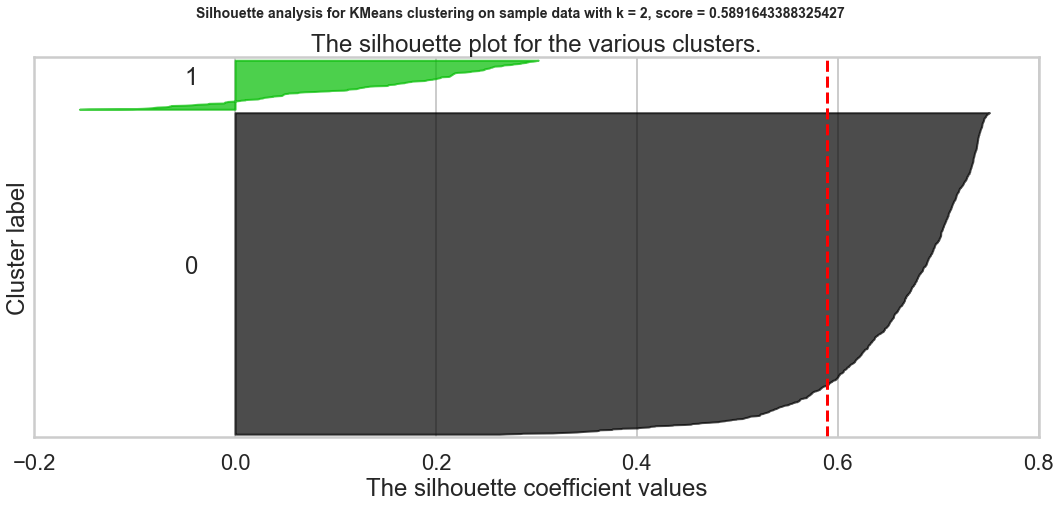

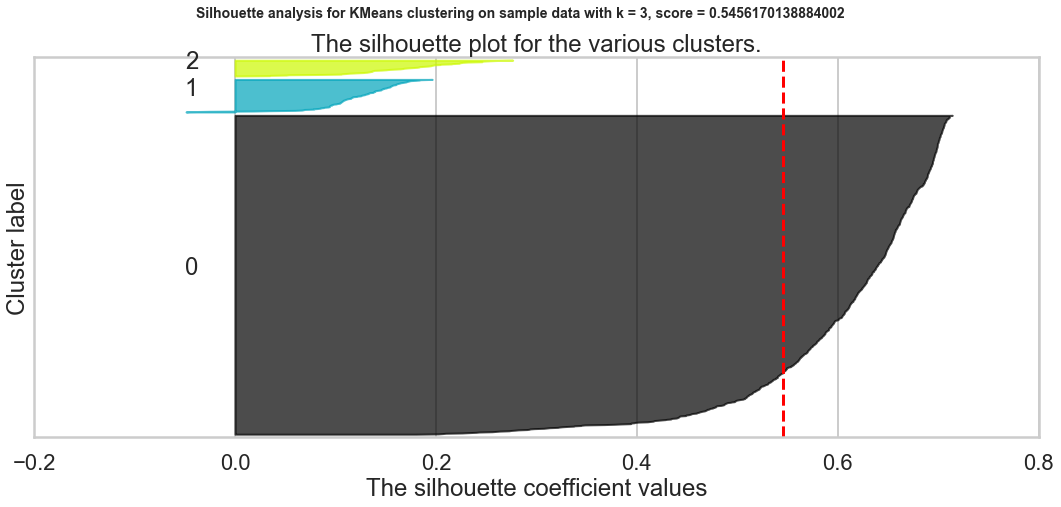

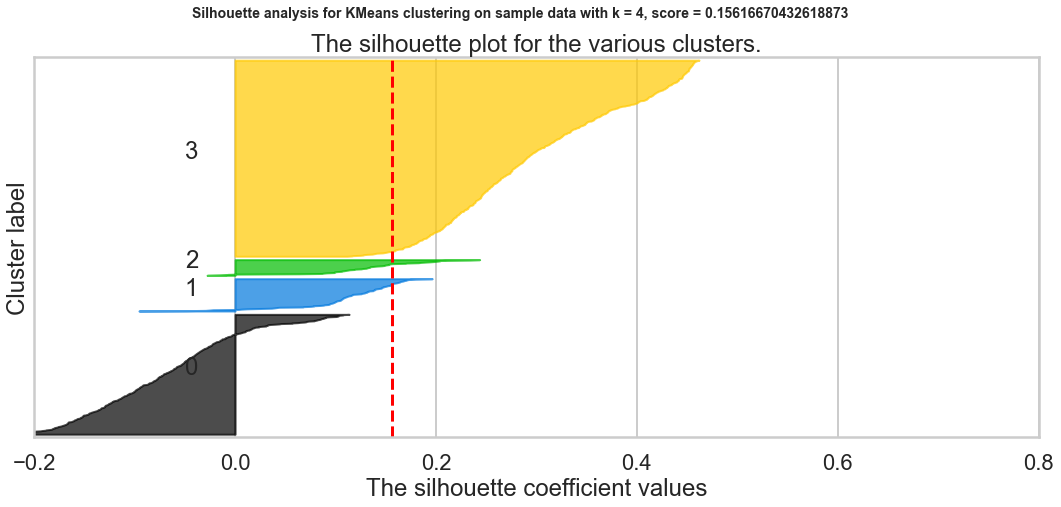

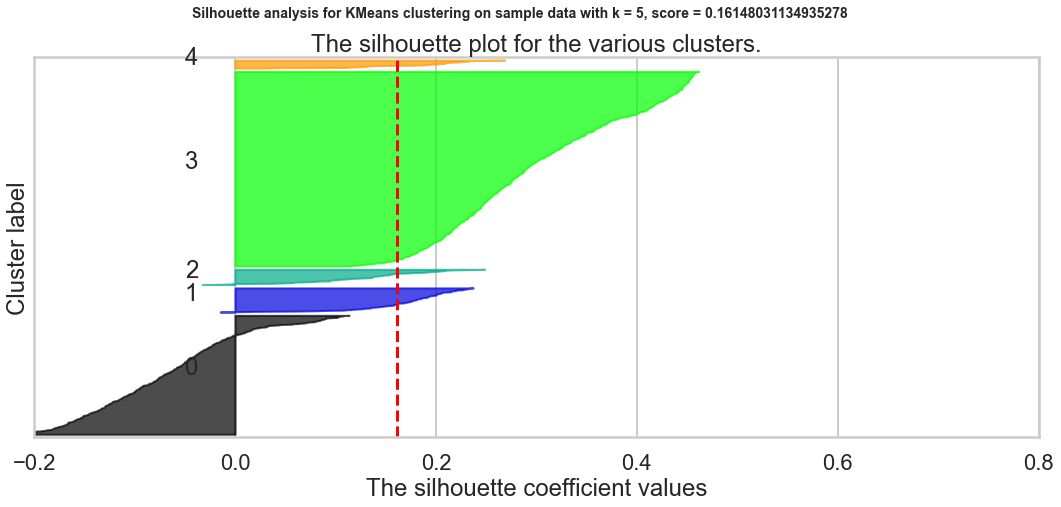

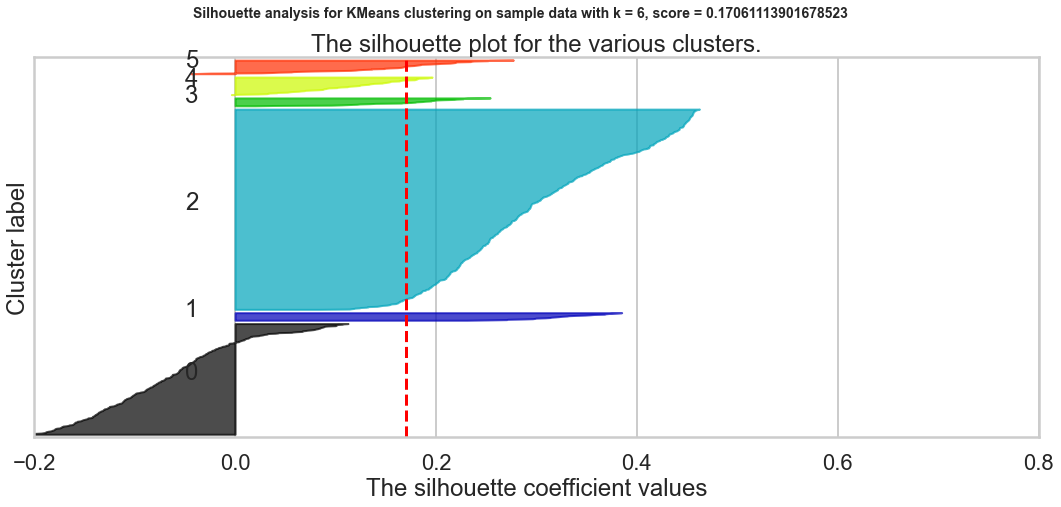

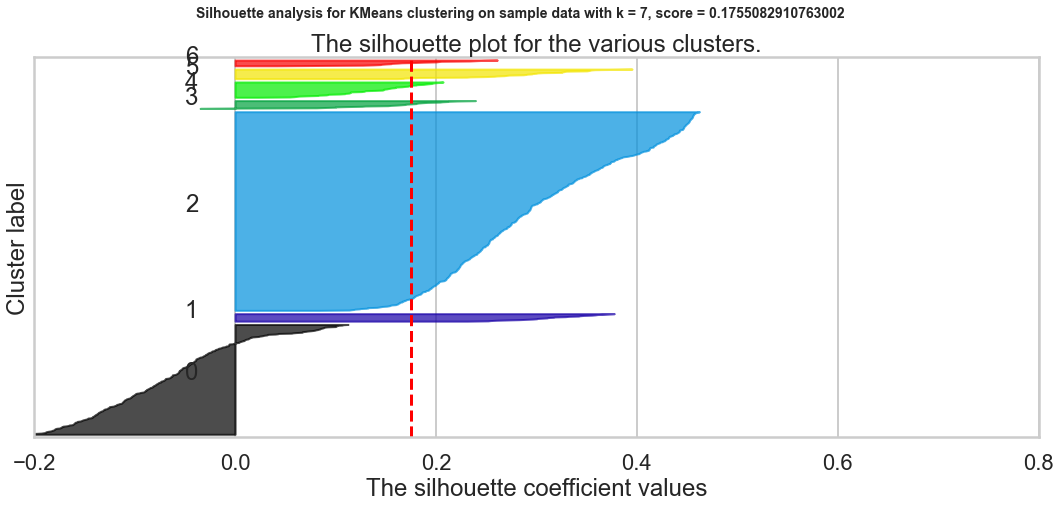

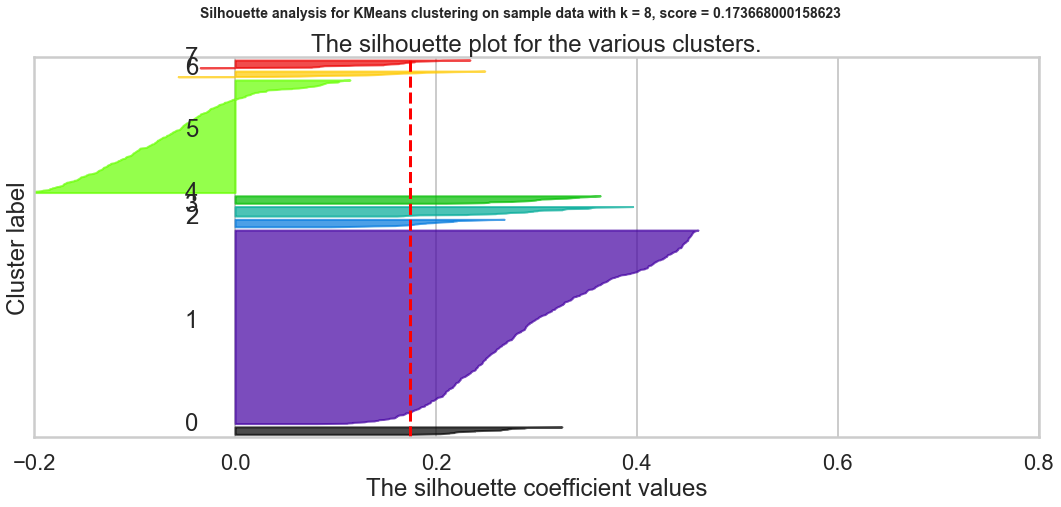

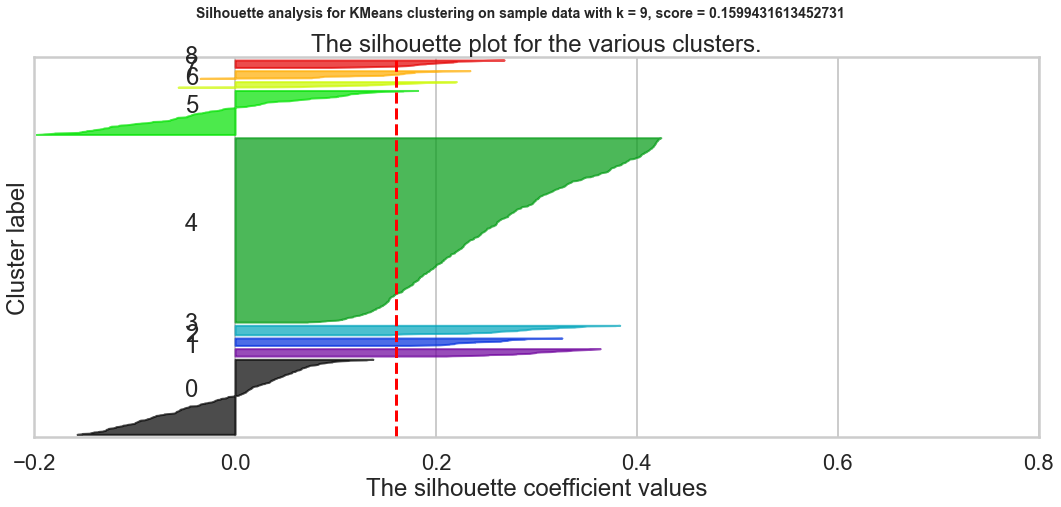

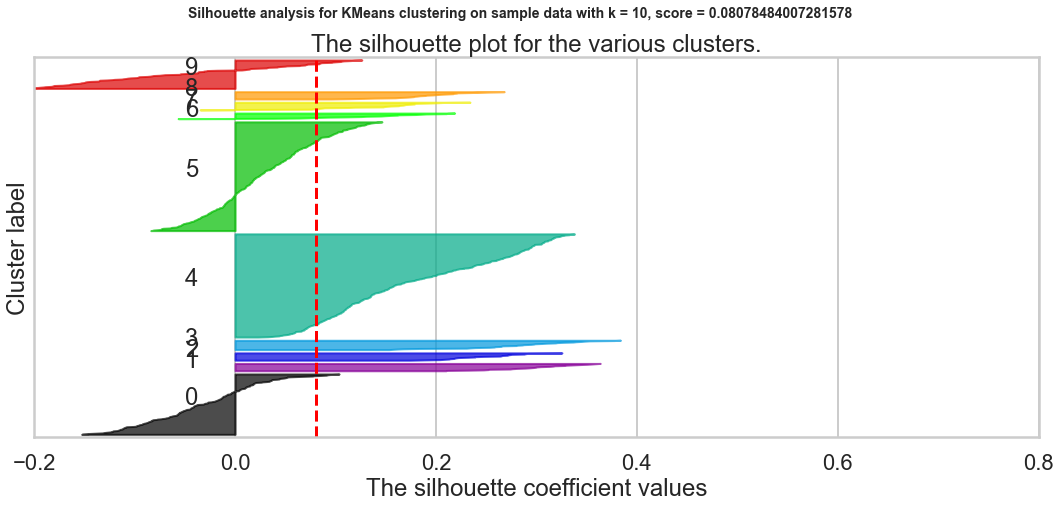

In [10]:
# Your turn.
K = range(2,11)
X = x_cols_scaled

for k in K:
    # Create a subplot
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(18, 7)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.2, 0.8])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    # Initialize the clusterer with n_clusters=k and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For k =", k, "The average silhouette_score is :", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with k = {}, score = {}".format(k,silhouette_avg) ),
                 fontsize=14, fontweight='bold')

plt.show()

Silhouette analysis shows that our best choice for k might be 2 or 3 clusters. One thing to be aware of is that if we choose so few clusters, then the silhouette analysis shows that most of our points would fall into only one of the clusters, leading to an unbalanced set. 

#### 6.2.3 Evaluation<a id='6.2.3_Evaluation'></a>

Let's dive right into evaluation of the models with different n_clusters.

In [11]:
df_kmm_results = pd.DataFrame(columns=['variable','value','k_clusters'])
K = range(2,37)

for k in K:
    kmm = KMeans(n_clusters=k, random_state=42)
    labels = kmm.fit_predict(x_cols_scaled)
    df_kmm_results = kmeans_evaluate_models(k, df_kmm_results, labels)

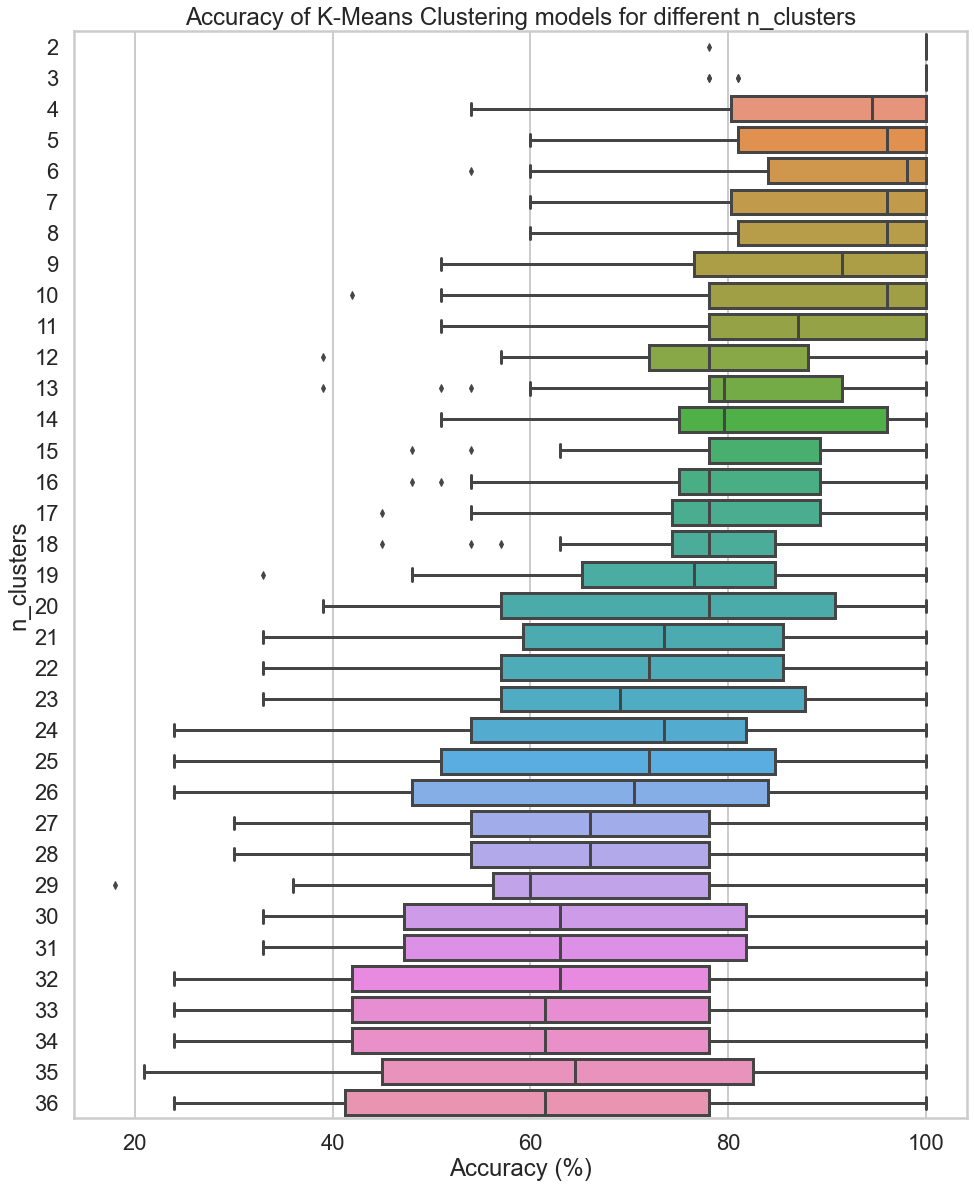

In [12]:
# plot accuracy
df_kmm_results_accuracy = df_kmm_results[df_kmm_results['variable'] == 'accuracy']

f, ax = plt.subplots(figsize=(16,20))
g = sns.boxplot(x="value", y="k_clusters", orient="h", data=df_kmm_results_accuracy)
_ = plt.title("Accuracy of K-Means Clustering models for different n_clusters")
_ = plt.xlabel("Accuracy (%)")
_ = plt.ylabel("n_clusters")

We can see that accuracy declines rapidly starting at `n_clusters` > 11. Let's take a look at the spread of incorrect clusters as well.

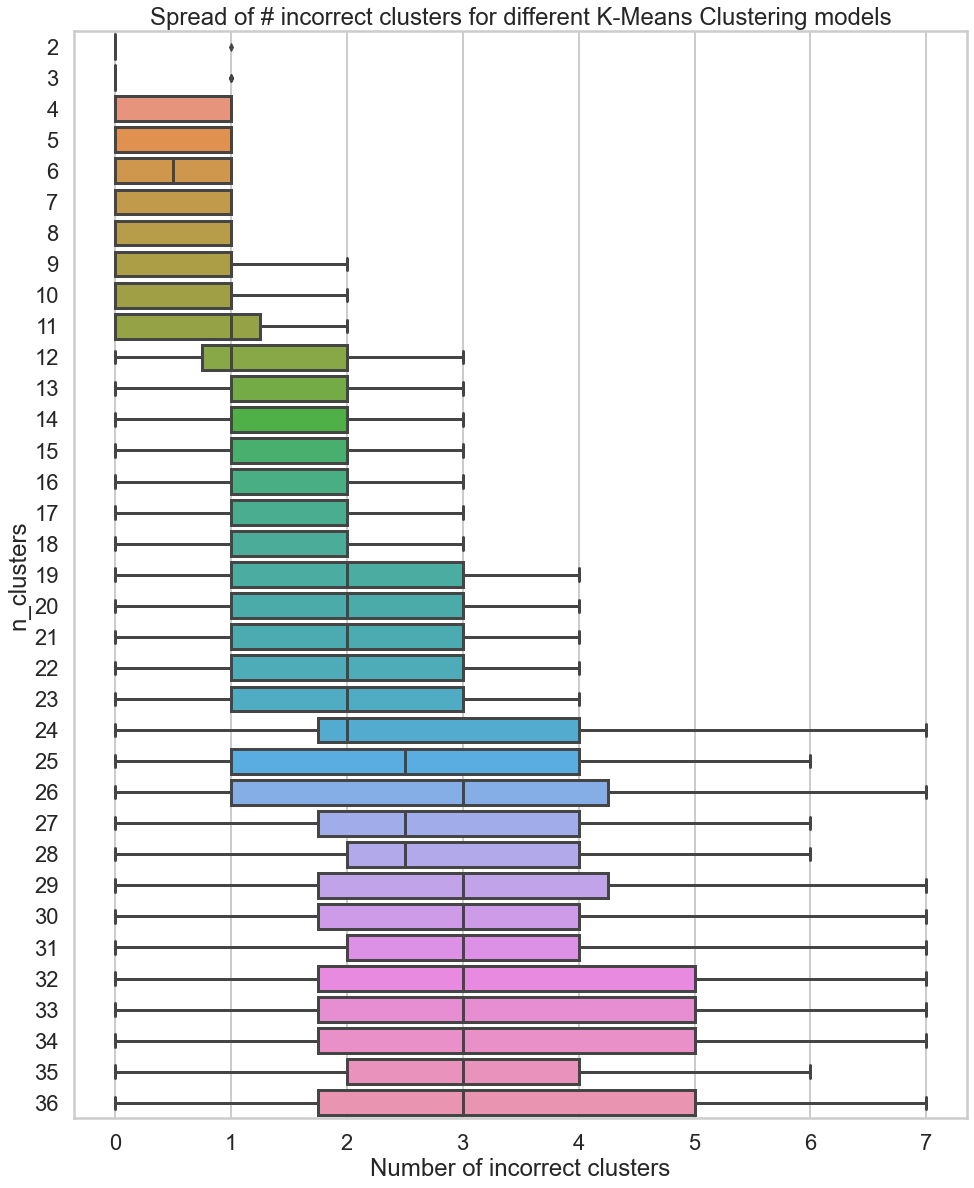

In [13]:
# plot number of incorrect clusters
df_kmm_results_n_incorrect_clusters = df_kmm_results[df_kmm_results['variable'] == 'n_incorrect_clusters']

f, ax = plt.subplots(figsize=(16,20))
g = sns.boxplot(x="value", y="k_clusters", orient="h", data=df_kmm_results_n_incorrect_clusters)
_ = plt.title("Spread of # incorrect clusters for different K-Means Clustering models")
_ = plt.xlabel("Number of incorrect clusters")
_ = plt.ylabel("n_clusters")

Again, this confirms that we should focus on `n_clusters` < 9, so as to limit data points from being too spread out into different clusters.

In [14]:
df_kmm_results_accuracy = df_kmm_results_accuracy.astype({"value": int})
df_kmm_results_accuracy[df_kmm_results_accuracy['k_clusters'] < 9].groupby(['k_clusters','variable']).describe()

value                                                    \
                    count       mean        std   min     25%    50%    75%   
k_clusters variable                                                           
2          accuracy  36.0  99.388889   3.666667  78.0  100.00  100.0  100.0   
3          accuracy  36.0  97.722222   6.553564  78.0  100.00  100.0  100.0   
4          accuracy  36.0  89.250000  12.902658  54.0   80.25   94.5  100.0   
5          accuracy  36.0  89.944444  12.398029  60.0   81.00   96.0  100.0   
6          accuracy  36.0  91.083333  12.771341  54.0   84.00   98.0  100.0   
7          accuracy  36.0  89.777778  12.540474  60.0   80.25   96.0  100.0   
8          accuracy  36.0  89.944444  12.398029  60.0   81.00   96.0  100.0   

                            
                       max  
k_clusters variable         
2          accuracy  100.0  
3          accuracy  100.0  
4          accuracy  100.0  
5          accuracy  100.0  
6          accuracy  100.0  
7          accuracy  100.0  
8          accuracy  100.0

From this, limiting to 2 or 3 clusters does appear to be the right choice.

### 6.3 Applying PCA<a id='6.3_Applying_PCA'></a>

Let's apply PCA. In previous notebooks, we found that nearly 90% of the variance in our features could be explained by choosing 3 components.

In [15]:
# reduce dimensionality down to 3 components
X = x_cols_scaled
pca = PCA(n_components=3)
pca_features = pca.fit_transform(X)

# create data frame with Neighborhood, three PCA components x, y, and z, and we will add cluster_id once determined by model
df_pca = pd.DataFrame(df.Neighborhood)
df_pca['x'] = pca_features[:,0]
df_pca['y'] = pca_features[:,1]
df_pca['z'] = pca_features[:,2]

#### 6.3.1 The Elbow Method<a id='6.3.1_The_Elbow_Method'></a>

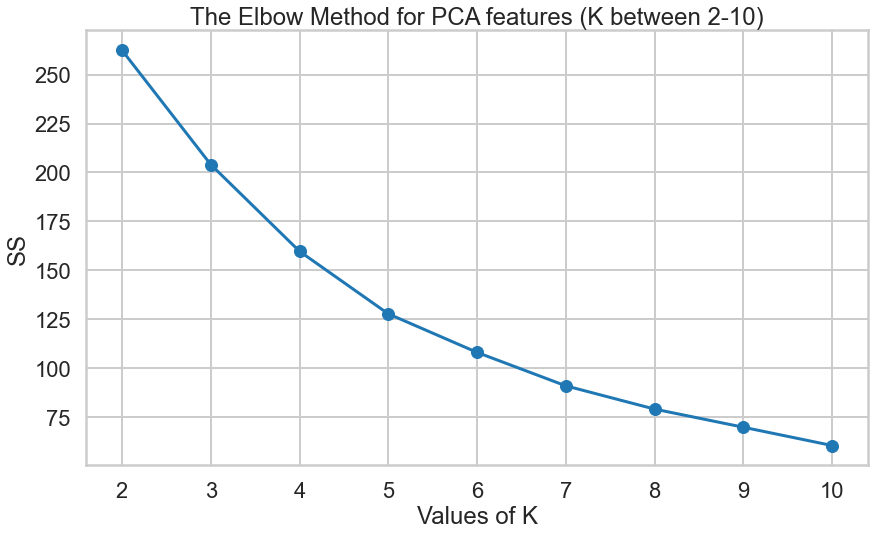

In [16]:
# let's plot the Elbow method for pca_features, focusing on n_clusters < 11
inertias = list()
K = range(2,11)

for k in K:
    kmeansModel = KMeans(n_clusters=k, random_state=42)
    kmeansModel.fit(pca_features)
    inertias.append(kmeansModel.inertia_) 

plt.figure(figsize=(14,8))
plt.plot(K, inertias, marker='o') 
plt.xlabel('Values of K') 
plt.ylabel('SS') 
plt.title('The Elbow Method for PCA features (K between 2-10)') 
plt.show() 

#### 6.3.2 Evaluation<a id='6.3.2_Evaluation'></a>

Let's dive right into evaluation of the models using PCA.

In [17]:
df_kmm_pca_results = pd.DataFrame(columns=['variable','value','k_clusters'])
K = range(2,11)

for k in K:
    kmm = KMeans(n_clusters=k, random_state=42)
    labels = kmm.fit_predict(pca_features)
    df_kmm_pca_results = kmeans_evaluate_models(k, df_kmm_pca_results, labels)

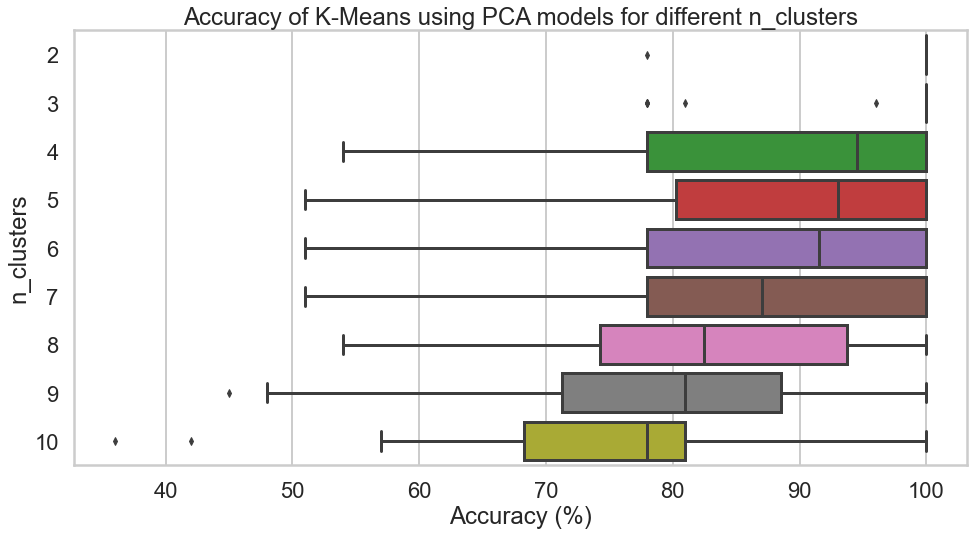

In [18]:
# plot accuracy
df_kmm_pca_results_accuracy = df_kmm_pca_results[df_kmm_pca_results['variable'] == 'accuracy']

f, ax = plt.subplots(figsize=(16,8))
g = sns.boxplot(x="value", y="k_clusters", orient="h", data=df_kmm_pca_results_accuracy)
_ = plt.title("Accuracy of K-Means using PCA models for different n_clusters")
_ = plt.xlabel("Accuracy (%)")
_ = plt.ylabel("n_clusters")

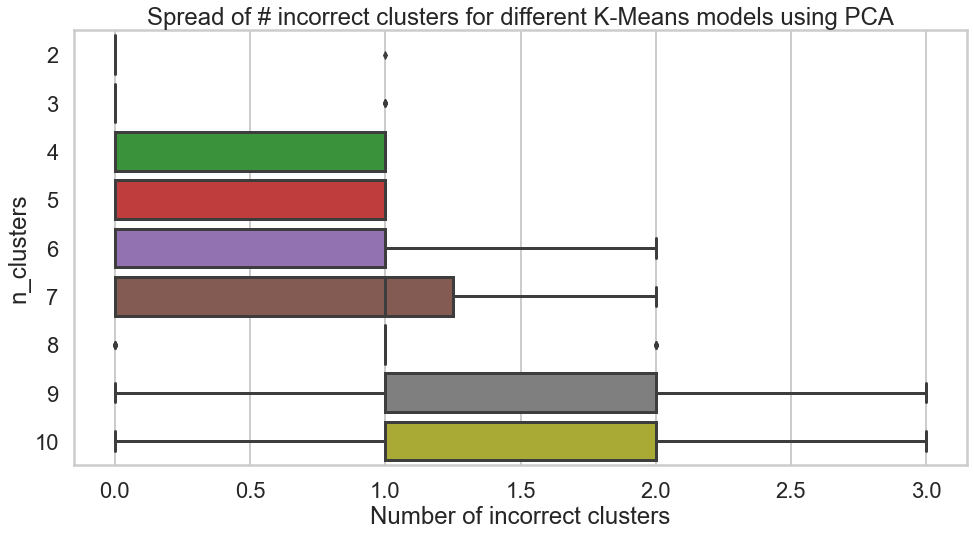

In [19]:
# plot number of incorrect clusters
df_kmm_pca_results_n_incorrect_clusters = df_kmm_pca_results[df_kmm_pca_results['variable'] == 'n_incorrect_clusters']

f, ax = plt.subplots(figsize=(16,8))
g = sns.boxplot(x="value", y="k_clusters", orient="h", data=df_kmm_pca_results_n_incorrect_clusters)
_ = plt.title("Spread of # incorrect clusters for different K-Means models using PCA")
_ = plt.xlabel("Number of incorrect clusters")
_ = plt.ylabel("n_clusters")

It appears that we should focus on `n_clusters` <= 5.

In [20]:
df_kmm_pca_results_accuracy = df_kmm_pca_results_accuracy.astype({"value": int})
df_kmm_pca_results_accuracy[df_kmm_pca_results_accuracy['k_clusters'] < 6].groupby(['k_clusters','variable']).describe()

value                                                    \
                    count       mean        std   min     25%    50%    75%   
k_clusters variable                                                           
2          accuracy  36.0  99.388889   3.666667  78.0  100.00  100.0  100.0   
3          accuracy  36.0  97.527778   6.780165  78.0  100.00  100.0  100.0   
4          accuracy  36.0  88.305556  14.026138  54.0   78.00   94.5  100.0   
5          accuracy  36.0  88.138889  14.204934  51.0   80.25   93.0  100.0   

                            
                       max  
k_clusters variable         
2          accuracy  100.0  
3          accuracy  100.0  
4          accuracy  100.0  
5          accuracy  100.0

These accuracy results for the PCA models are nearly identical to the models that don't use PCA. In fact, the previous set of models had a lower standard deviation. This appears to be one instance where PCA isn't necessary.

### 6.4 In-depth look at model results<a id='6.4_In-depth_look_at_model_results'></a>

Let's take an in-depth look at specific K-Means model results.

In [21]:
# n_clusters = 2

kmm_2 = KMeans(n_clusters=2, random_state=42)
labels = kmm_2.fit_predict(x_cols_scaled)
kmm_2_df = pd.DataFrame({'labels':labels, 'neighborhoods':removed_col_values['Neighborhood']})
pd.crosstab(kmm_2_df['neighborhoods'], kmm_2_df['labels'])

labels,0,1
neighborhoods,,
Bayview Hunters Point,0,33
Bernal Heights,33,0
Castro/Upper Market,33,0
Chinatown,33,0
Excelsior,33,0
Financial District/South Beach,7,26
Glen Park,33,0
Haight Ashbury,33,0
Hayes Valley,33,0


The table shows that the only neighborhood split between the 2 clusters is Financial District/South Beach.

In [22]:
# n_clusters = 3

kmm_3 = KMeans(n_clusters=3, random_state=42)
labels = kmm_3.fit_predict(x_cols_scaled)
kmm_3_df = pd.DataFrame({'labels':labels, 'neighborhoods':removed_col_values['Neighborhood']})
pd.crosstab(kmm_3_df['neighborhoods'], kmm_3_df['labels'])

labels,0,1,2
neighborhoods,,,
Bayview Hunters Point,0,0,33
Bernal Heights,33,0,0
Castro/Upper Market,33,0,0
Chinatown,33,0,0
Excelsior,33,0,0
Financial District/South Beach,7,26,0
Glen Park,33,0,0
Haight Ashbury,33,0,0
Hayes Valley,33,0,0


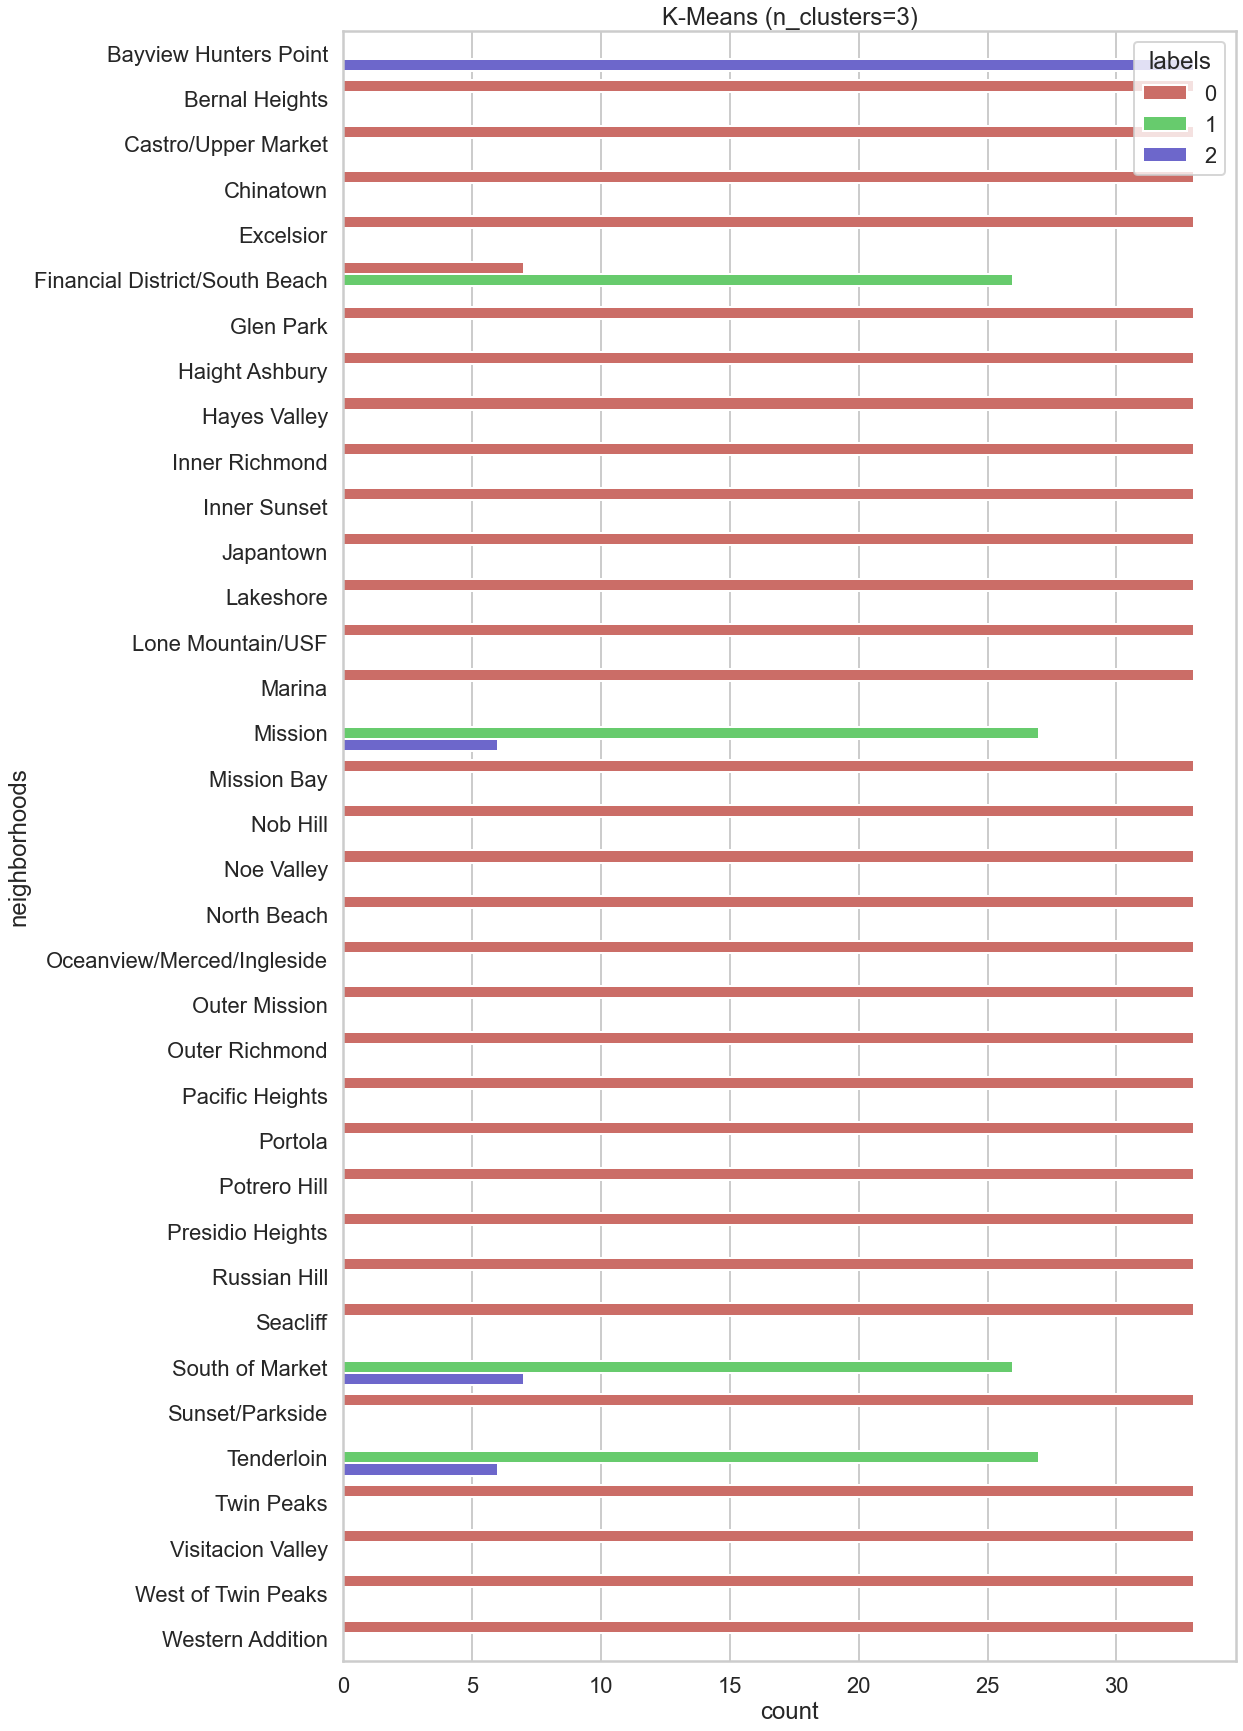

In [23]:
f, ax = plt.subplots(figsize=(16,30))
g = sns.countplot(y="neighborhoods", hue="labels", data=kmm_3_df, palette="hls")
_ = plt.title("K-Means (n_clusters=3)")

In [24]:
# n_clusters = 4

kmm_4 = KMeans(n_clusters=4, random_state=42)
labels = kmm_4.fit_predict(x_cols_scaled)
kmm_4_df = pd.DataFrame({'labels':labels, 'neighborhoods':removed_col_values['Neighborhood']})
pd.crosstab(kmm_4_df['neighborhoods'], kmm_4_df['labels'])

labels,0,1,2,3
neighborhoods,,,,
Bayview Hunters Point,33,0,0,0
Bernal Heights,0,28,0,5
Castro/Upper Market,0,32,0,1
Chinatown,0,0,0,33
Excelsior,0,24,0,9
Financial District/South Beach,0,7,26,0
Glen Park,0,0,0,33
Haight Ashbury,0,15,0,18
Hayes Valley,0,26,0,7


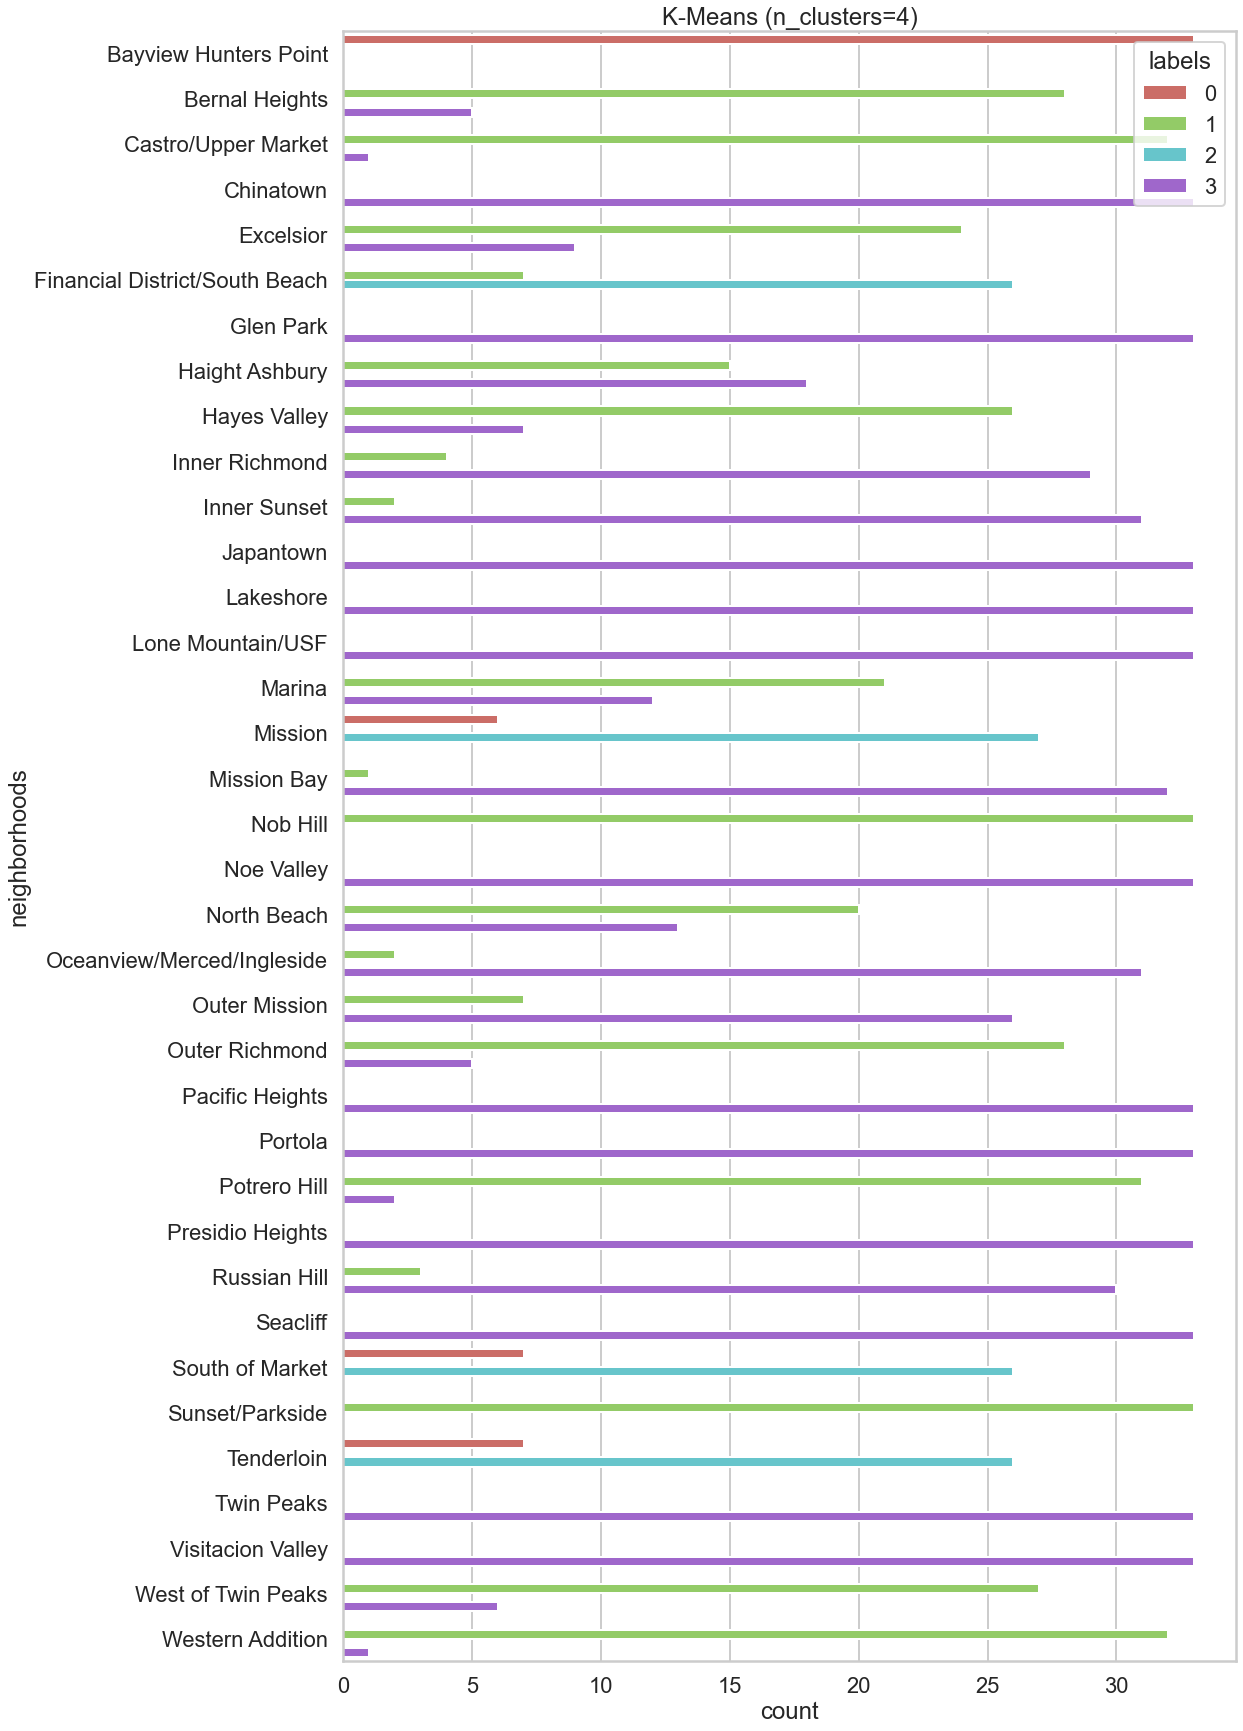

In [25]:
f, ax = plt.subplots(figsize=(16,30))
g = sns.countplot(y="neighborhoods", hue="labels", data=kmm_4_df, palette="hls")
_ = plt.title("K-Means (n_clusters=4)")

We can see that by `n_clusters` = 4, some neighborhoods are starting to be spread amongst too many clusters.

## 7 Other Models<a id='7_Other_Models'></a>

Let's look at some other models

### 7.1 Affinity Propagation<a id='7.1_Affinity_Propagation'></a>

Let's look at Affinity Propagation, which is interesting because it will choose the number of clusters based on the data provided. We will use it on the PCA features computed above (`n_components` = 3).

In [26]:
from sklearn.cluster import AffinityPropagation

X = pca_features
affinityPropagationModel = AffinityPropagation(random_state=42)
clusters = affinityPropagationModel.fit_predict(pca_features)
centers = affinityPropagationModel.cluster_centers_
print("The number of clusters is: ", len(centers))

The number of clusters is:  52


That's a lot of clusters! This probably isn't an appropriate model.

### 7.2 Agglomerative Clustering<a id='7.2_Agglomerative_Clustering'></a>

Let's look at Agglomerative Clustering. We will use it on the PCA features computed above (`n_components` = 3), and pass in `n_clusters` = 3.

In [27]:
from sklearn.cluster import AgglomerativeClustering

X = pca_features
agglomerativeClusteringModel = AgglomerativeClustering(n_clusters=3)
clusters = agglomerativeClusteringModel.fit_predict(pca_features)
ac_df = pd.DataFrame({'labels':clusters, 'neighborhoods':removed_col_values['Neighborhood']})
pd.crosstab(ac_df['neighborhoods'], ac_df['labels'])

labels,0,1,2
neighborhoods,,,
Bayview Hunters Point,33,0,0
Bernal Heights,0,33,0
Castro/Upper Market,0,33,0
Chinatown,0,33,0
Excelsior,0,33,0
Financial District/South Beach,0,7,26
Glen Park,0,33,0
Haight Ashbury,0,33,0
Hayes Valley,0,33,0


It's no surprise that the results from Agglomerative Clustering looks so similar to K-Means.

In [28]:
# let's plot a dendrogram for this model
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

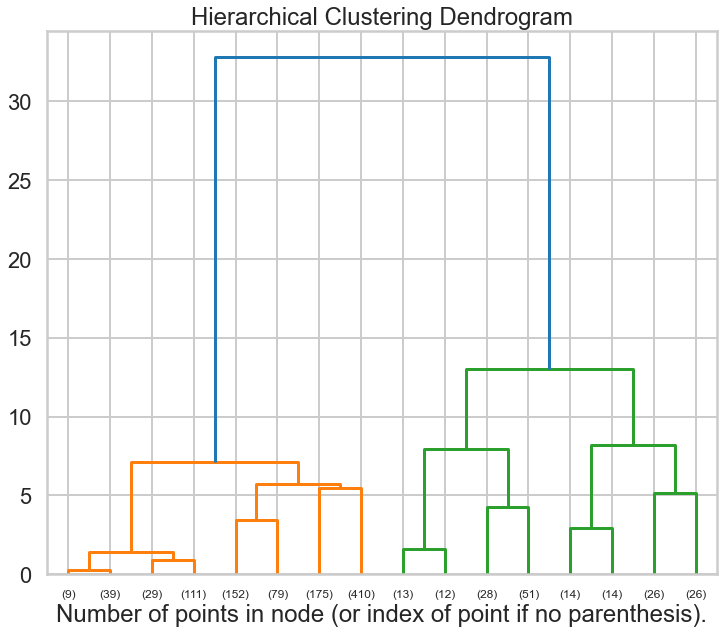

In [29]:
acm = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
clusters = acm.fit_predict(pca_features)

plt.figure(figsize=(12,10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(acm, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

The dendrogram shows that there are 2 well-defined clusters, possibly 3, but more than that and it gets messy.

## 8 Cluster Analysis<a id='8_Cluster_Analysis'></a>

Let's go back to our K-Means model with `n_clusters` = 3 clusters and look at how it aligns with the features in our original data set.

In [30]:
# all the features
x_cols.columns.values

array(['Arson', 'Assault', 'Burglary', 'Case Closure', 'Civil Sidewalks',
       'Courtesy Report', 'Disorderly Conduct', 'Drug Offense',
       'Drug Violation', 'Embezzlement', 'Family Offense', 'Fire Report',
       'Forgery And Counterfeiting', 'Fraud', 'Gambling', 'Homicide',
       'Human Trafficking (A), Commercial Sex Acts',
       'Human Trafficking (B), Involuntary Servitude',
       'Human Trafficking, Commercial Sex Acts', 'Larceny Theft',
       'Liquor Laws', 'Lost Property', 'Malicious Mischief',
       'Miscellaneous Investigation', 'Missing Person',
       'Motor Vehicle Theft', 'Motor Vehicle Theft?', 'Non-Criminal',
       'Offences Against The Family And Children', 'Other',
       'Other Miscellaneous', 'Other Offenses', 'Prostitution', 'Rape',
       'Recovered Vehicle', 'Robbery', 'Sex Offense', 'Stolen Property',
       'Suicide', 'Suspicious', 'Suspicious Occ', 'Traffic Collision',
       'Traffic Violation Arrest', 'Vandalism', 'Vehicle Impounded',
       'Vehi

In [61]:
kmeans3 = KMeans(n_clusters=3, random_state=42)

df_k3 = pd.DataFrame(x_cols.index)
df_k3['cluster_id'] = kmeans3.fit_predict(x_cols_scaled)

df_k3_full = pd.melt(df_k3.join(x_cols).drop(columns=0).groupby('cluster_id').sum().reset_index(), id_vars=['cluster_id'])

# scale each feature's counts across clusters, such that we see a percentage of how many incidents apply to each cluster
df_k3_pct = df_k3_full.groupby(['variable','cluster_id']).agg({'value':'sum'}).groupby(level=0).apply(lambda x: x / float(x.sum())).reset_index()
df_k3_pct = df_k3_pct.pivot(index='cluster_id', columns='variable', values='value')
df_k3_pct.T

cluster_id,0,1,2
variable,,,
311 External Request,0.740784,0.180222,0.078994
Abandoned Vehicle,0.819835,0.065697,0.114468
Arson,0.514433,0.285567,0.200000
Assault,0.429228,0.418313,0.152459
Blocked Street or SideWalk,0.619770,0.305022,0.075208
...,...,...,...
Vehicle Misplaced,0.608434,0.343373,0.048193
Warrant,0.351394,0.542513,0.106093
Weapons Carrying Etc,0.360830,0.425101,0.214069


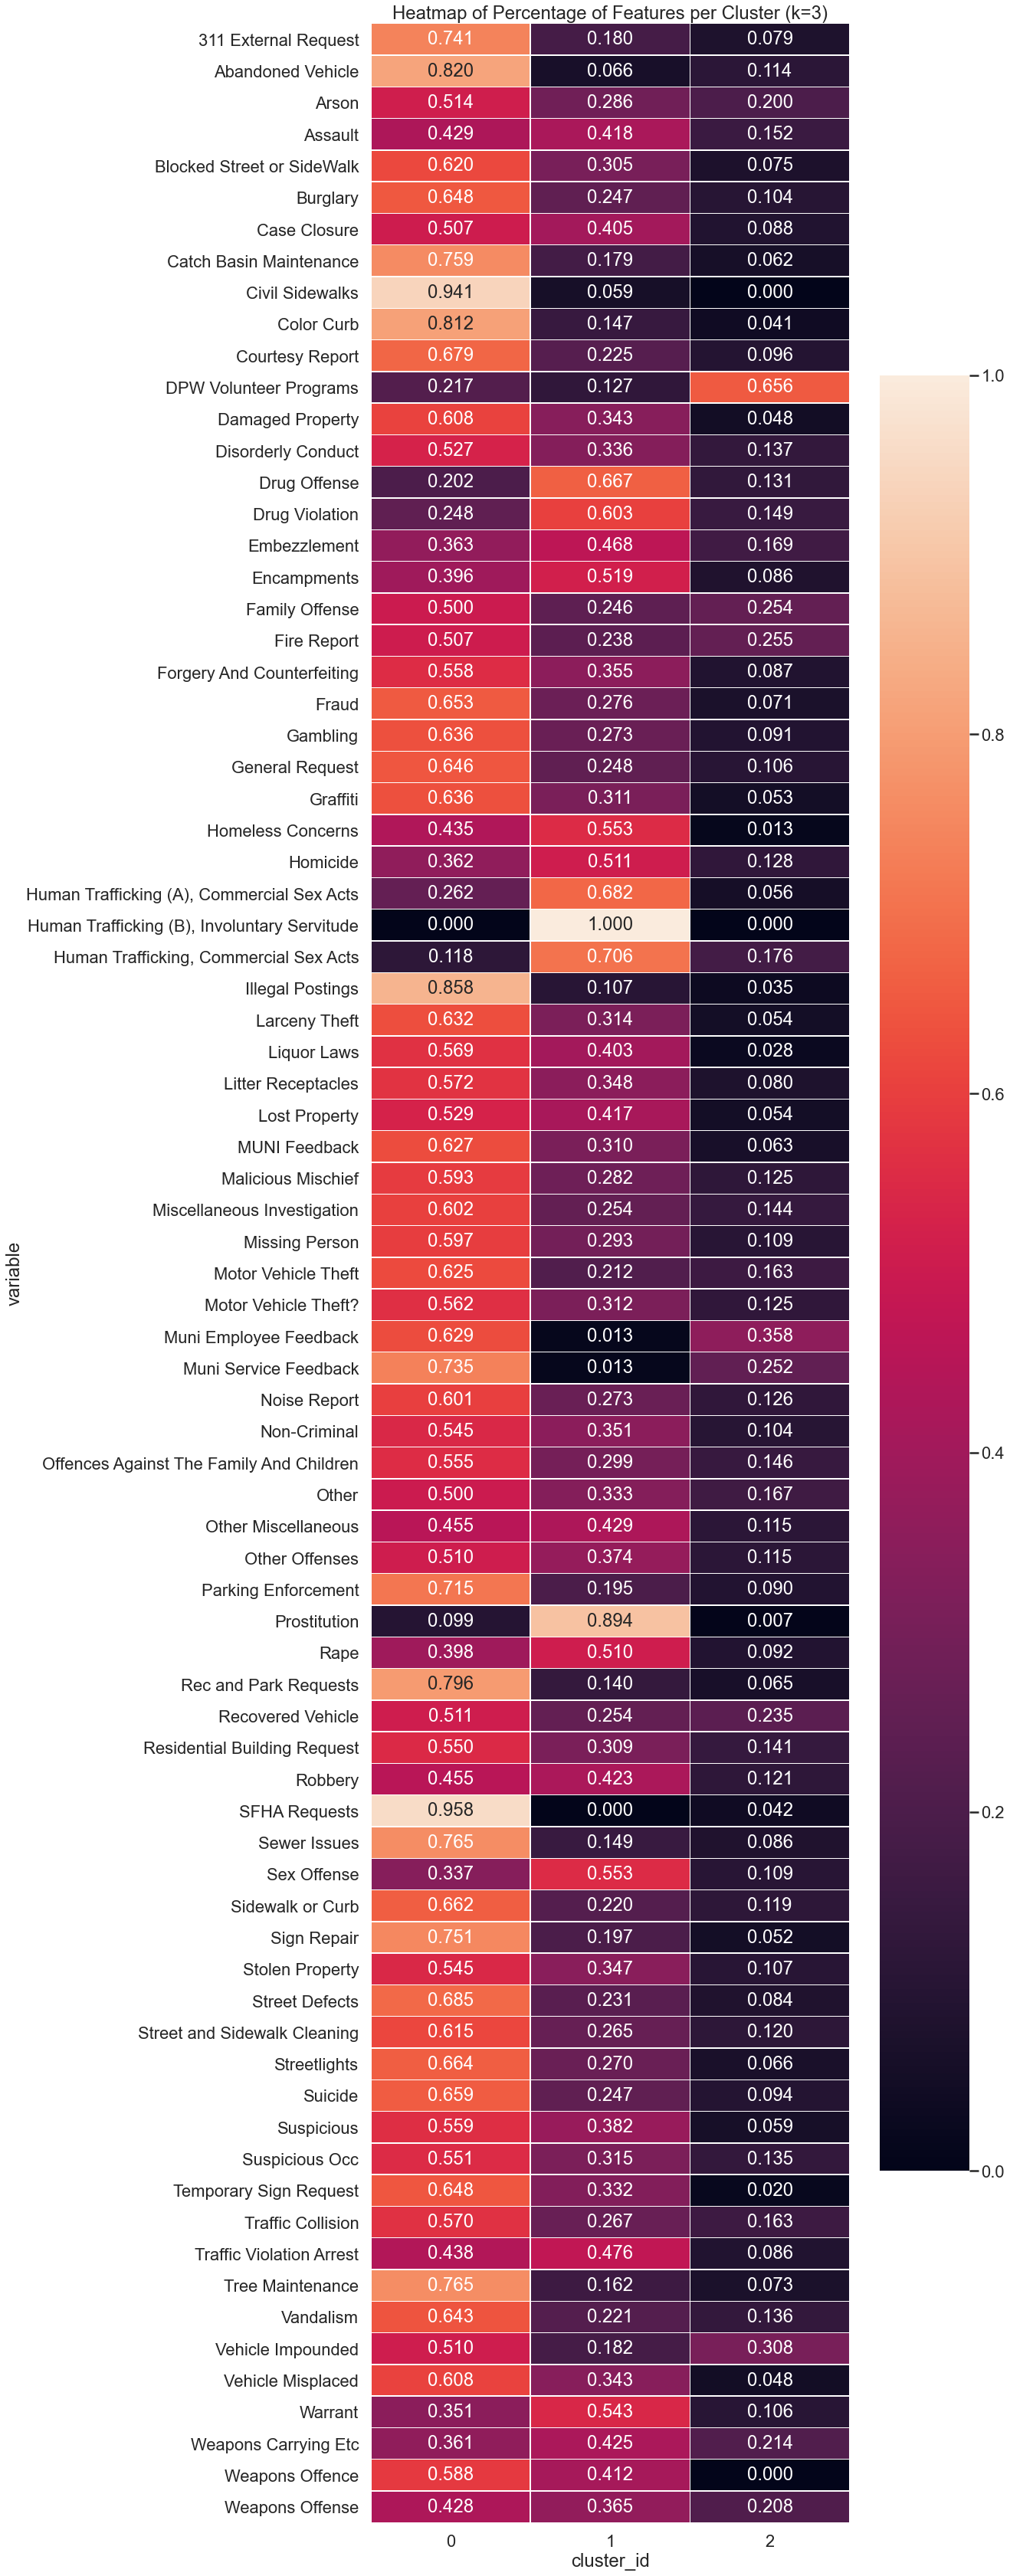

In [91]:
f, ax = plt.subplots(figsize=(14,60))
g = sns.heatmap(df_k3_pct.T, annot=True, fmt=".3f", linewidths=.5)
_ = plt.title("Heatmap of Percentage of Features per Cluster (k=3)")

__We were previously aware that `cluster_id = 0` is the "catch-all" cluster, so let's focus on the other 2 clusters.__

__`cluster_id = 1` has the majority of the following:__
  * Drug Offense
  * Drug Violation
  * Embezzlement
  * Encampments
  * Homeless Concerns
  * Homicide
  * Human Trafficking
  * Prostitution
  * Rape
  * Sex Offense
  * Warrant
  
We can see that some of those features likely strongly correlate with each other (i.e. Prostitution and Sex Offense), but it appears that this cluster of neighborhoods captures more serious incidents.

__`cluster_id = 2` has the following identifiers:__
  * Vast majority of DPW Volunteer Programs
  * Nearly no Encampments or Homeless Concerns when compared with the other two clusters.

To clarify the "DPW Volunteer Programs": this is a Category of 311 requests. San Francisco's Department of Public Works runs various volunteer initiatives, focusing on keeping streets clean and removing graffiti. The 311 cases of this type are issued when, for example, a volunteer needs additional cleaning supplies or paint from the city to remove graffiti. 

It is somewhat surprising that this cluster has nearly no Encampments or Homeless Concerns, when those issues are so pervasive across the rest of the city.

__Let's look at the neighborhoods per cluster to tie this analysis together.__

In [92]:
# let's recreate the neighborhoods per cluster data frame
df_k3_neighborhoods = pd.DataFrame({'cluster_id':df_k3['cluster_id'], 'neighborhoods':removed_col_values['Neighborhood']})
df_k3_neighborhoods['value'] = 1
df_k3_neighborhoods_pct = df_k3_neighborhoods.groupby(['neighborhoods','cluster_id']).agg({'value':'sum'}).groupby(level=0).apply(lambda x: x / float(x.sum())).reset_index().pivot(index='cluster_id', columns='neighborhoods', values='value').fillna(0)


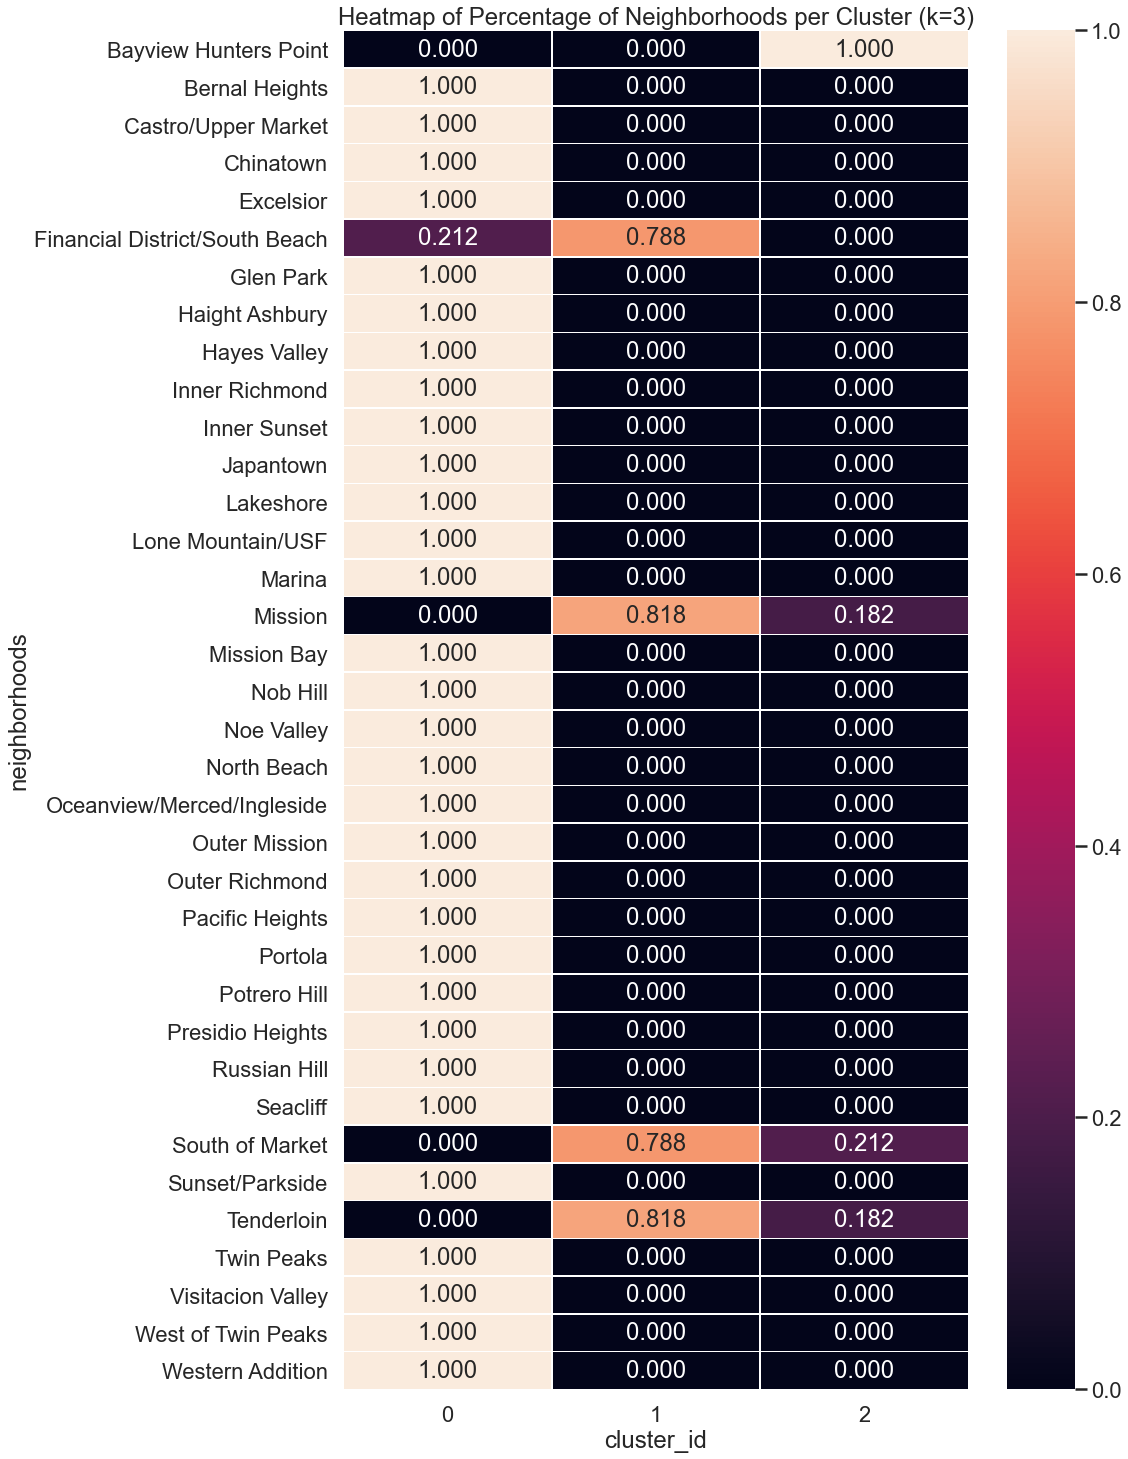

In [93]:
f, ax = plt.subplots(figsize=(14,25))
g = sns.heatmap(df_k3_neighborhoods_pct.T, annot=True, fmt=".3f", linewidths=.5)
_ = plt.title("Heatmap of Percentage of Neighborhoods per Cluster (k=3)")

We can consider `cluster_id = 0`, which contains the majority of the neighborhoods, to include a "normal" distribution of San Francisco.

That would make the following neighborhoods "outliers":
  * Bayview Hunters Point
  * Financial District/South Beach
  * Mission
  * South of Market
  * Tenderloin

__Bayview Hunters Point__ falls entirely in `cluster_id = 2`. From our earlier analysis of features, it appears that this neighborhood has graffiti and street cleaning issues, but nearly no homeless concerns. 

__Financial District/South Beach__ has approximately 80% in `cluster_id = 1` and 20% in `cluster_id = 0`. The rest of the neighborhoods, __Mission__, __South of Market__, and __Tenderloin__, also have approximately 80% in `cluster_id = 1` but the remaining 20% in `cluster_id = 2`. These neighborhoods, over the past decade, have been undergoing drastic changes in neighborhood makeup due to startups, construction (new buildings and renovation of old buildings), and an influx of jobs and people. This analysis shows that, although many aspects of these neighborhoods have improved tremendously, work must still be done to clear out problematic issues.